In [ ]:
import numpy as np
import pandas as pd
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import sklearn
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')
df.head()


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
df.shape

(20491, 2)

# Data Cleaning

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [ ]:
df.isnull().sum()

Review    0
Rating    0
dtype: int64

In [ ]:
df.duplicated().sum()

0

In [ ]:
# Sentiment is a copy of rating initially
df['Sentiment'] = df['Rating']

df['Sentiment'] = df['Sentiment'].replace({1: 'Negative',
                                 2: 'Negative',
                                 3: 'Neutral',
                                 4: 'Positive',
                                 5: 'Positive'})

df.drop(['Rating'], axis = 1, inplace = True)
df.head()

,Review,Sentiment
0,nice hotel expensive parking got good deal sta...,Positive
1,ok nothing special charge diamond member hilto...,Negative
2,nice rooms not 4* experience hotel monaco seat...,Neutral
3,"unique, great stay, wonderful time hotel monac...",Positive
4,"great stay great stay, went seahawk game aweso...",Positive


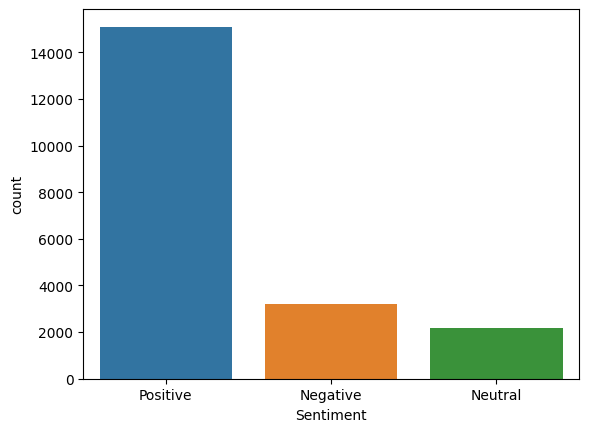

In [ ]:
#Visual
sns.countplot(x=df['Sentiment'])
plt.show()

# Text Preprocessing

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Initialize the frequency dictionary
frequency = {}

def clean_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Tokenize the text
    tokens = word_tokenize(text)

    # Clean and preprocess the tokens
    cleaned_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalpha() and token.lower() not in stop_words]

    # Update the word frequency
    for token in cleaned_tokens:
        frequency[token] = frequency.get(token, 0) + 1

    # Join the cleaned tokens to form a cleaned text
    cleaned_text = ' '.join(cleaned_tokens)

    return cleaned_text


In [ ]:
# Applying text preprocessing methods to df['Review']
df['Review'] = df['Review'].apply(clean_text)
df.head()

,Review,Sentiment
0,nice hotel expensive parking got good deal sta...,Positive
1,ok nothing special charge diamond member hilto...,Negative
2,nice room experience hotel monaco seattle good...,Neutral
3,unique great stay wonderful time hotel monaco ...,Positive
4,great stay great stay went seahawk game awesom...,Positive


In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df["category_encoded"] = encoder.fit_transform(df["Sentiment"]) + 1
df.head()

,Review,Sentiment,category_encoded
0,nice hotel expensive parking got good deal sta...,Positive,3
1,ok nothing special charge diamond member hilto...,Negative,1
2,nice room experience hotel monaco seattle good...,Neutral,2
3,unique great stay wonderful time hotel monaco ...,Positive,3
4,great stay great stay went seahawk game awesom...,Positive,3


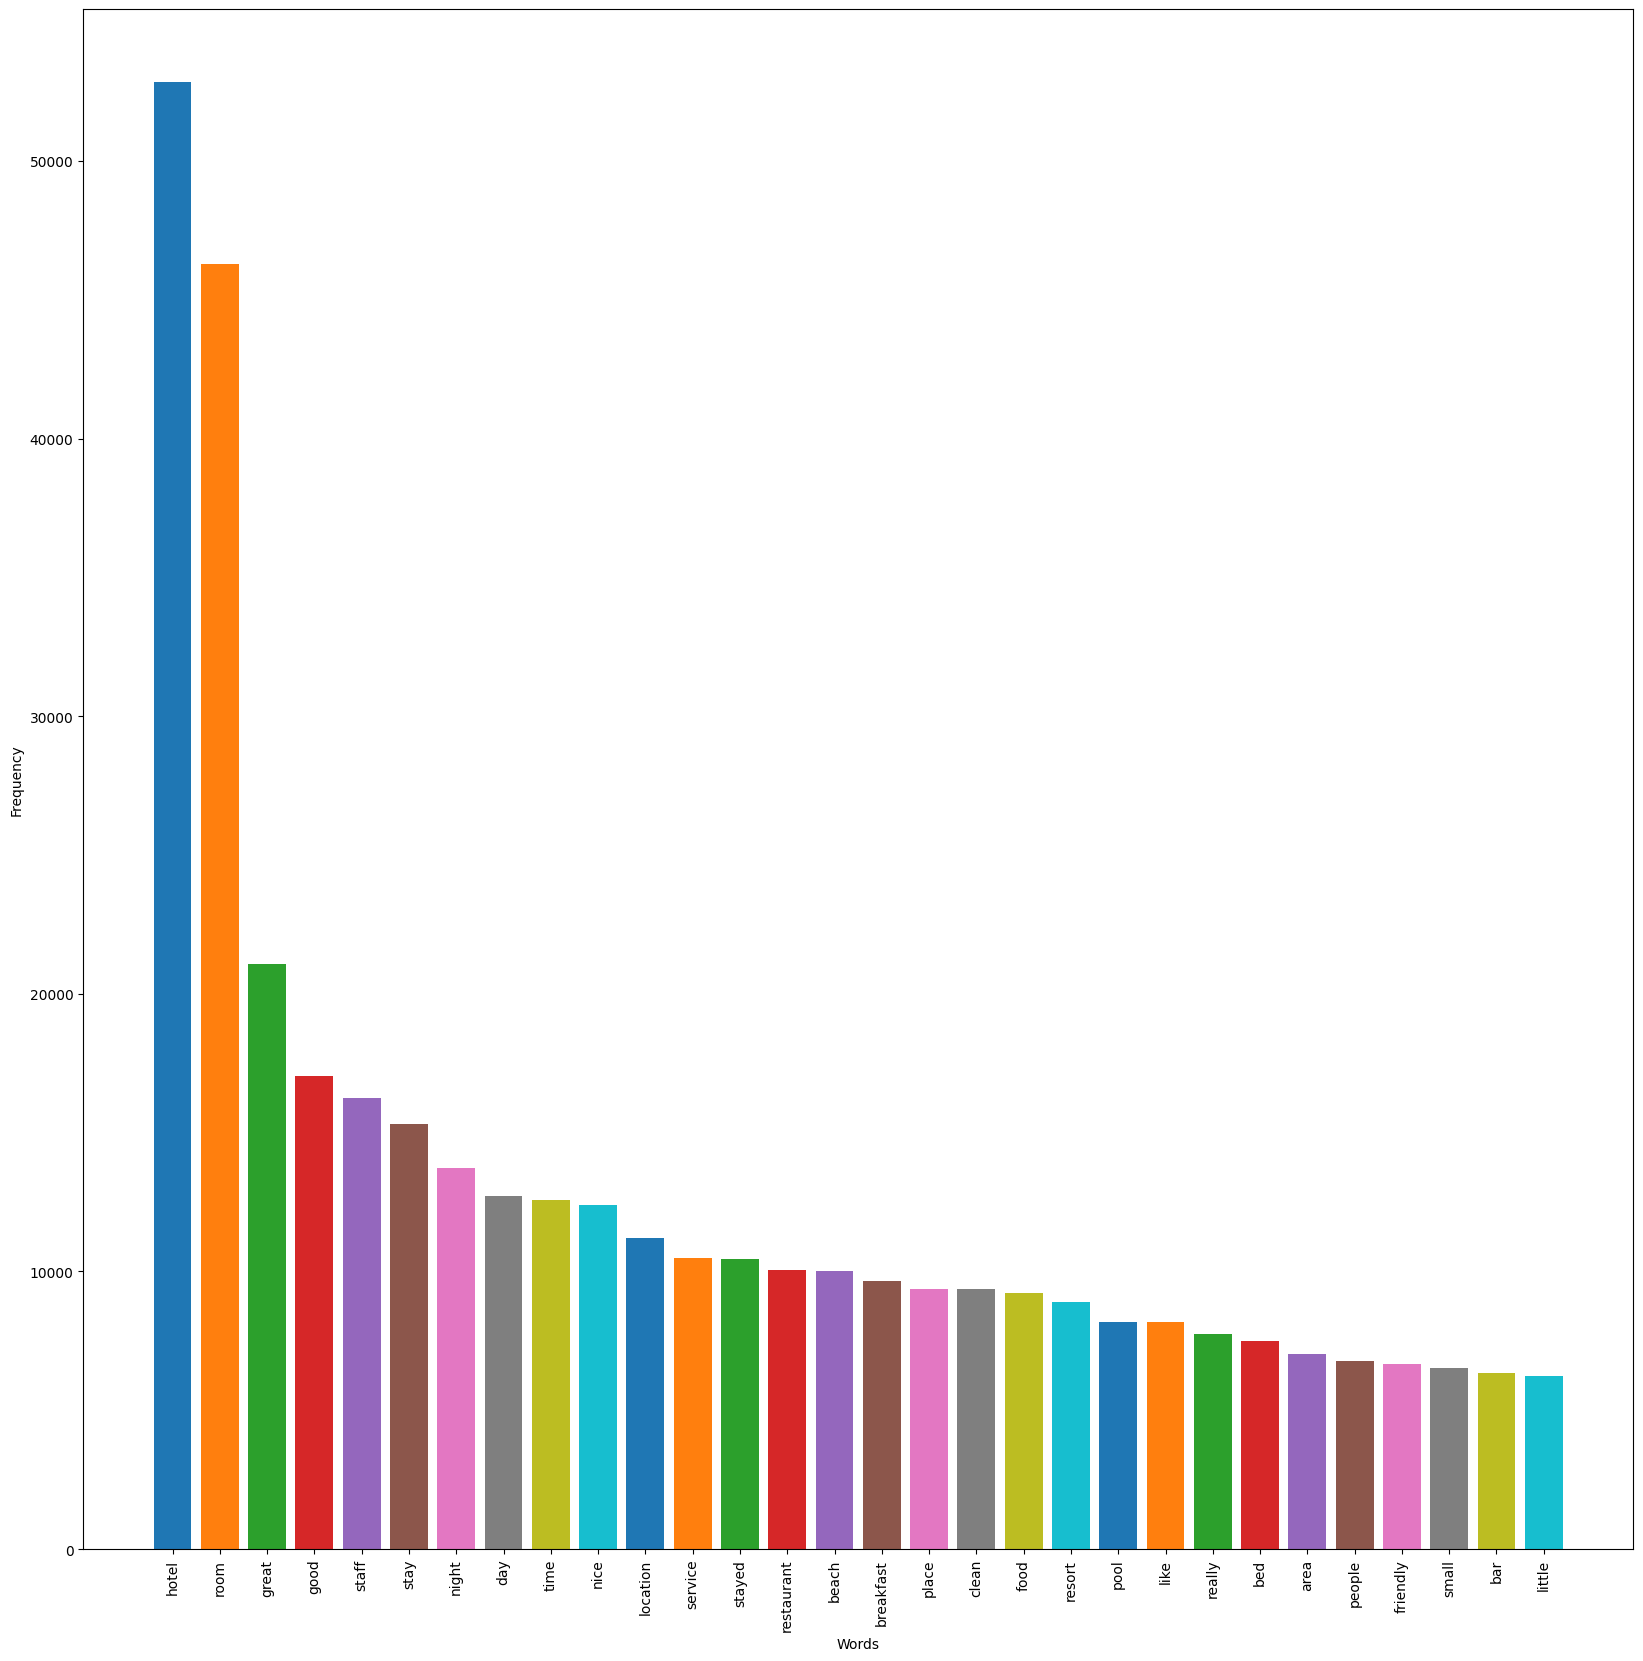

In [ ]:

# Visualize the most repeated words
collection = sorted(frequency.items(), key=itemgetter(1), reverse = True)


# visualization with pyplot
plt.figure(figsize=(20,20))
plt.ylabel("Frequency")
plt.xlabel("Words")
plt.xticks(rotation=90)
for word , freq in collection[:30]:
    plt.bar(word, freq)
plt.show()


## Model Building
# Logistic Regression

In [ ]:
x = df['Review']
y = df['category_encoded']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
x = vec.fit_transform(x).toarray()

In [ ]:
from sklearn.model_selection import train_test_split
#Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [ ]:
from sklearn.model_selection import GridSearchCV
# Define the hyperparameter grid to search over
param_grid = {'C': [1, 10, 100]}

# Perform grid search to find the best C value
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid , cv=3)

grid_search.fit(X_train, y_train)

# Get the best C value
best_C = grid_search.best_params_['C']

# Print the best C value and the corresponding mean cross-validated score
print("Best C value:", grid_search.best_params_['C'])
print("Best score:", grid_search.best_score_)

Best C value: 1
Best score: 0.8541361639824304


In [ ]:
from sklearn.metrics import classification_report

# Train the logistic regression model with the best C value
lr = LogisticRegression(C=best_C)
lr.fit(X_train, y_train)

# Make predictions on the test set
lr_pred = lr.predict(X_test)

# Evaluate the model's accuracy
print("Classification Report for Logistic Regression: \n", classification_report(y_test, lr_pred))


Classification Report for Logistic Regression: 
               precision    recall  f1-score   support

           1       0.80      0.75      0.77       625
           2       0.55      0.18      0.27       432
           3       0.88      0.98      0.93      3042

    accuracy                           0.86      4099
   macro avg       0.74      0.64      0.66      4099
weighted avg       0.83      0.86      0.84      4099



# Neural Network

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
x = df['Review']

In [ ]:
encoder = LabelEncoder()
df["category_encoded"] = encoder.fit_transform(df["Sentiment"])
df.head()

,Review,Sentiment,category_encoded
0,nice hotel expensive parking got good deal sta...,Positive,2
1,ok nothing special charge diamond member hilto...,Negative,0
2,nice room experience hotel monaco seattle good...,Neutral,1
3,unique great stay wonderful time hotel monaco ...,Positive,2
4,great stay great stay went seahawk game awesom...,Positive,2


In [ ]:
y = df["category_encoded"]

In [ ]:
x = np.asarray(x)
y =  np.asarray(y)

In [ ]:
# Tokenize the text
max_words = 2000  # Consider only the top 2000 words in the dataset
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)

In [ ]:
# Find the maximum sequence length
maxlen = max(len(sequence) for sequence in sequences)
print(f"Maximum Sequence Length: {maxlen}")

Maximum Sequence Length: 1407


In [ ]:
# Pad sequences to have consistent length
padded_sequences = pad_sequences(sequences, maxlen=maxlen)
padded_sequences

array([[   0,    0,    0, ...,  168,  217,    7],
       [   0,    0,    0, ...,  799,    1,  501],
       [   0,    0,    0, ...,   42, 1680,   77],
       ...,
       [   0,    0,    0, ...,  376, 1420,  974],
       [   0,    0,    0, ...,  275,   57,  307],
       [   0,    0,    0, ...,  153,  121,   17]])

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

In [ ]:
#Define the plotting function

def plot_curve(epochs, hist, list_of_metrics):
   # Plot a graph of the metric vs. epochs.
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]  # Access the metric from the history object
        plt.plot(range(1, len(x) + 1), x, label=m)

    plt.legend()

print("Loaded the plot_curve function.")

Loaded the plot_curve function.


In [ ]:
# Create a neural network (NN) model with a specified number of neurons in a hidden layer.
def NN_model(neurons):
    # Define a sequential model
    model = tf.keras.Sequential([
        # Embedding layer for processing sequences of integers (word indices)
        tf.keras.layers.Embedding(input_dim=max_words, output_dim=8, input_length=maxlen),
        # Flatten layer to flatten the embedded input
        tf.keras.layers.Flatten(),
        # Dense hidden layer with specified number of neurons and ReLU activation function
        tf.keras.layers.Dense(units=neurons, activation='relu'),
        # Dropout layer for regularization to prevent overfitting
        tf.keras.layers.Dropout(rate=0.5),
        # Output layer with 3 units (for 3 classes) and softmax activation for multi-class classification
        tf.keras.layers.Dense(units=3, activation='softmax')
    ])

    # Compile the model with specified optimizer, loss function, and metrics
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


# Train the provided model with training data
def train_model(model):
    # Fit the model to the training data
    history = model.fit(X_train, y_train, batch_size=2000, epochs=10, validation_split=0.2)

    # Extract the epoch information and training history metrics
    epochs = history.epoch
    hist = pd.DataFrame(history.history)

    return epochs, hist


In [ ]:
# hyperparameter Tunning
# Create a KerasClassifier model with a specified function to create the base model
model = KerasClassifier(model= NN_model)

# Define the grid search parameters
neurons = [16, 32, 64, 128]

# Define the parameter grid for the grid search
param_grid = dict(model__neurons=neurons)

# Perform grid search using KerasClassifier, optimizing for the specified parameters
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# Summarize the grid search results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Extract and print mean test scores, standard deviations, and corresponding parameters
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Retrieve the best number of neurons from the grid search results
best_neurons = grid_result.best_params_['model__neurons']


513/513 [==============================] - 7s 11ms/step - loss: 0.4941 - accuracy: 0.8204
Best: 0.840166 using {'model__neurons': 128}
0.836506 (0.003143) with: {'model__neurons': 16}
0.831869 (0.005651) with: {'model__neurons': 32}
0.835469 (0.005535) with: {'model__neurons': 64}
0.840166 (0.004755) with: {'model__neurons': 128}


Epoch 1/10
7/7 [==============================] - 3s 269ms/step - loss: 1.0541 - accuracy: 0.6162 - val_loss: 0.7853 - val_accuracy: 0.7396
Epoch 2/10
7/7 [==============================] - 1s 203ms/step - loss: 0.8000 - accuracy: 0.7335 - val_loss: 0.7416 - val_accuracy: 0.7392
Epoch 3/10
7/7 [==============================] - 1s 205ms/step - loss: 0.7325 - accuracy: 0.7339 - val_loss: 0.6573 - val_accuracy: 0.7396
Epoch 4/10
7/7 [==============================] - 1s 204ms/step - loss: 0.6400 - accuracy: 0.7504 - val_loss: 0.5728 - val_accuracy: 0.7661
Epoch 5/10
7/7 [==============================] - 1s 202ms/step - loss: 0.5378 - accuracy: 0.8042 - val_loss: 0.4670 - val_accuracy: 0.8262
Epoch 6/10
7/7 [==============================] - 1s 203ms/step - loss: 0.4487 - accuracy: 0.8389 - val_loss: 0.4363 - val_accuracy: 0.8408
Epoch 7/10
7/7 [==============================] - 1s 206ms/step - loss: 0.4016 - accuracy: 0.8534 - val_loss: 0.4226 - val_accuracy: 0.8429
Epoch 8/10
7/7 [====

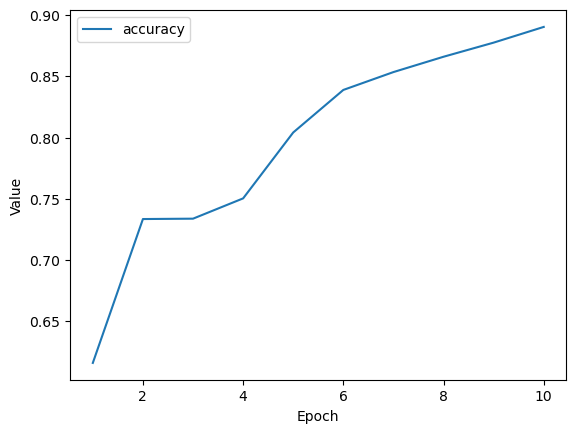

In [ ]:

# Create the model.
my_model = NN_model(best_neurons)

# Train the model on the training set.
epochs, hist = train_model(my_model)

# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

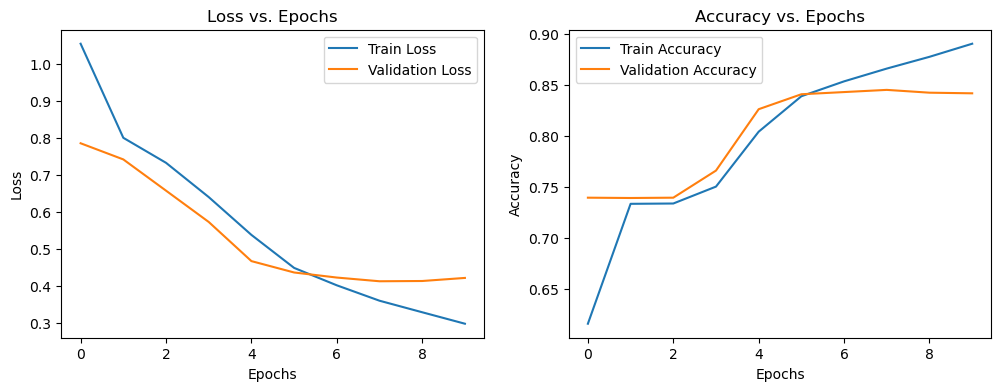

In [ ]:
# Plotting the loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the accuracy
plt.subplot(1, 2, 2)
plt.plot(hist['accuracy'], label='Train Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Evaluate against the test set.
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_test, y=y_test, batch_size=2000)


 Evaluate the new model against the test set:
3/3 [==============================] - 0s 30ms/step - loss: 0.4139 - accuracy: 0.8453


[0.41389936208724976, 0.845328152179718]

129/129 [==============================] - 1s 3ms/step


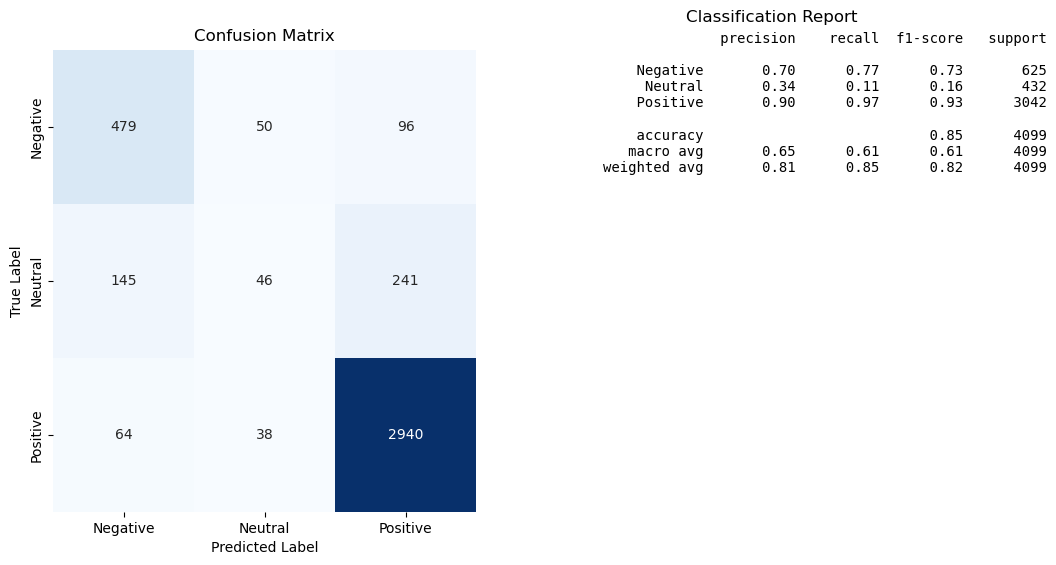

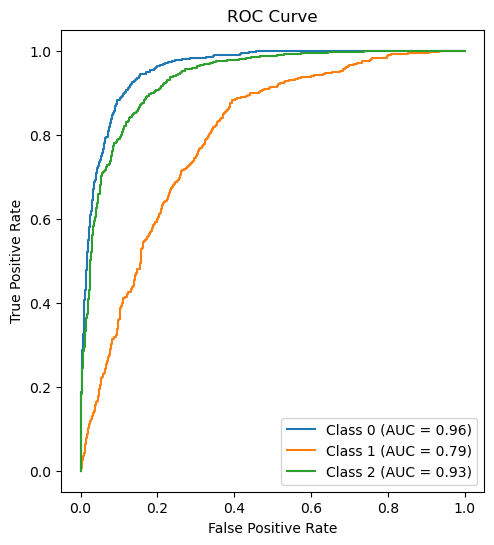

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_curve, auc,  confusion_matrix

# Confusion Matrix
y_pred_prob = my_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
cm = confusion_matrix(y_test, y_pred)

# Classification Report
classification_rep = classification_report(y_test, y_pred, target_names=["Negative", "Positive", "Neutral"])

# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # 3 classes
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Plptting

# Confusion Matrix
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"], cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Classification Report
plt.subplot(1, 2, 2)
classification_rep = classification_report(y_test, y_pred, target_names=["Negative", "Neutral", "Positive"])
plt.text(0.1, 0.7, classification_rep, {'fontsize': 10}, fontfamily='monospace')
plt.title('Classification Report', pad=20)
plt.axis('off')

plt.show()

plt.figure(figsize=(12, 6))
# ROC Curve
plt.subplot(1, 2, 1)
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()


# **Ensemble model**


In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Review'])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Sentiment'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the base models
lr = LogisticRegression()
xgb = XGBClassifier()
rf = RandomForestClassifier()

# Create the stacking ensemble
stacking_model = StackingClassifier(
    estimators=[('lr', lr), ('xgb', xgb), ('rf', rf)],
    final_estimator=LogisticRegression()
)

# Define the parameter grid for each base model
param_grid_lr = {'C': [0.1, 1, 10]}
param_grid_xgb = {'xgb_max_depth': [3, 5, 7], 'xgb_n_estimators': [100, 200, 300]}
param_grid_rf = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]}

# Create the GridSearchCV objects for each base model
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5)
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5)

# Train the base models with hyperparameter tuning
grid_search_lr.fit(X_train, y_train)
grid_search_xgb.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)

# Get the best base models
best_lr = grid_search_lr.best_estimator_
best_xgb = grid_search_xgb.best_estimator_
best_rf = grid_search_rf.best_estimator_

# Set the best base models in the stacking ensemble
stacking_model.estimators = [('lr', best_lr), ('xgb', best_xgb), ('rf', best_rf)]

# Train the stacking ensemble
stacking_model.fit(X_train, y_train)

# Print the best parameters found for each base model
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best parameters for Random Forest:", grid_search_rf.best_params_)

# Make predictions on the test set using the stacking ensemble
y_pred = stacking_model.predict(X_test)

# Inverse transform the predictions to get the original labels
y_pred_label = label_encoder.inverse_transform(y_pred)
y_test_label = label_encoder.inverse_transform(y_test)

# Evaluate the stacking ensemble
print(classification_report(y_test_label, y_pred_label))

Best parameters for Logistic Regression: {'C': 1}
Best parameters for XGBoost: {'xgb_max_depth': 3, 'xgb_n_estimators': 100}
Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 100}
              precision    recall  f1-score   support

    Negative       0.78      0.82      0.80       625
     Neutral       0.52      0.26      0.35       432
    Positive       0.91      0.97      0.94      3042

    accuracy                           0.87      4099
   macro avg       0.74      0.68      0.69      4099
weighted avg       0.85      0.87      0.85      4099



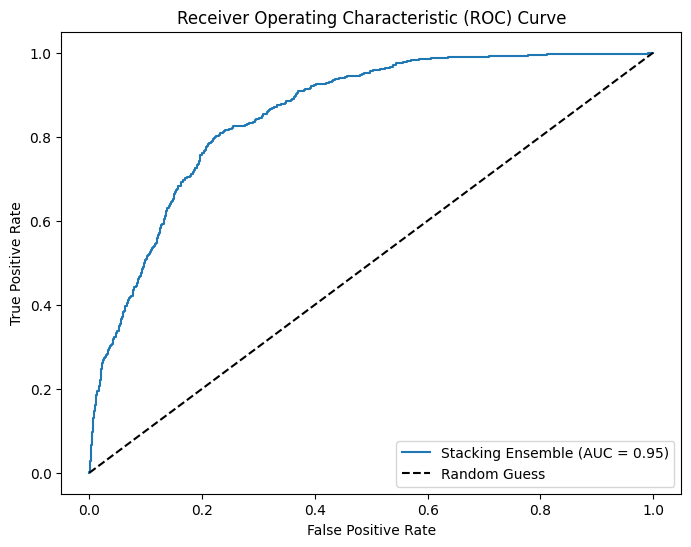

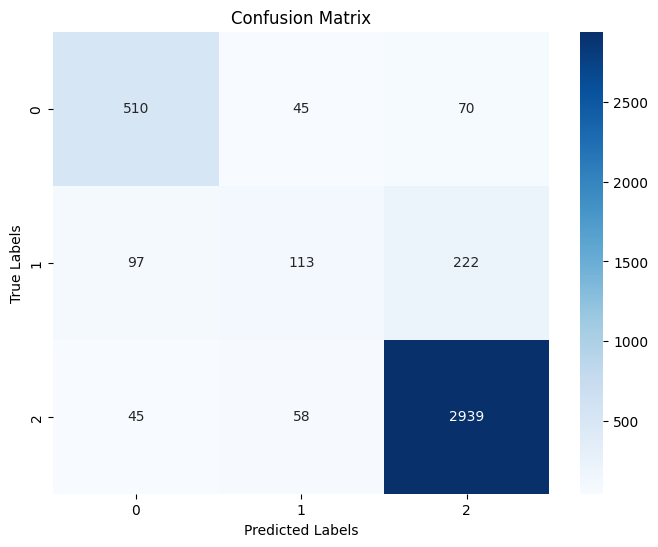

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns

# Calculate predicted probabilities for each class
y_prob = stacking_model.predict_proba(X_test)

# Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1], pos_label=1)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Stacking Ensemble (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()